# Bacteria Image Classification using EfficientNet

[Dataset](http://misztal.edu.pl/software/databases/dibas/).

In [1]:
##run this cell only on first run, after restarting runtime start running from the next cell
!pip install q keras==2.3.1
!pip install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 377 kB 12.7 MB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.7.0 requires keras<2.8,>=2.7.0rc0, but you have keras 2.3.1 which is incompatible.
     |████████████████████████████████| 2.9 MB 11.2 MB/s 
     |████████████████████████████████| 15.7 MB 203 kB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installat

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
IMG_PATH = '/content/drive/MyDrive/Bacteria-Dataset/' 

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [6]:
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
  !git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 171, done.
remote: Total 171 (delta 0), reused 0 (delta 0), pack-reused 171
Receiving objects: 100% (171/171), 5.44 MiB | 5.61 MiB/s, done.
Resolving deltas: 100% (98/98), done.
/content/efficientnet_keras_transfer_learning


In [7]:
from efficientnet import EfficientNetB0 as Net ## EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
from efficientnet import center_crop_and_resize, preprocess_input

In [ ]:
width = 224
height = 224
input_shape = (height, width, 3)

conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

Splitting images into (224,224) for larger dataset.

In [9]:
from PIL import Image
import numpy as np

def process_image(im, path, i):
    imarray = np.array(im)
    h, w = imarray.shape[:2]
    target_h, target_w = 224, 224
    j = 0
    for row in np.arange(h - target_h +1, step = target_h):
        for col in np.arange(w - target_w +1, step = target_w):

            img_new = imarray[row:row+target_h, col:col+target_w, :]
            img_new = Image.fromarray(img_new)
            
            if not os.path.exists(path + f"{i}_{j}" + ".png"):
              img_new.save(path + f"{i}_{j}" + ".png")
              j+= 1



In [ ]:
# import shutil
# shutil.rmtree('/content/images/')

In [10]:
if not os.path.exists('/content/images/'):
  os.mkdir('/content/images/')
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
      print(CLASS)
      if not os.path.exists('/content/images/'+CLASS):
        os.mkdir('/content/images/'+CLASS)
      for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
        if os.path.exists(IMG_PATH + CLASS + '/' + FILE_NAME):
          img = Image.open(IMG_PATH + CLASS + '/' + FILE_NAME)
          process_image(img, '/content/images/' + CLASS + '/',n)



Staphylococcus.saprophiticus
Staphylococcus.aureus
Lactobacillus.gasseri
Bacteroides.fragilis
Pseudomonas.aeruginosa
Enterococcus.faecium
Actinomyces.israeli
Candida.albicans
Lactobacillus.rhamnosus
Staphylococcus.epidermidis
Acinetobacter.baumanii


In [ ]:
# shutil.rmtree('/content/efficientnet_keras_transfer_learning/TEST')
# shutil.rmtree('/content/efficientnet_keras_transfer_learning/TRAIN')
# shutil.rmtree('/content/efficientnet_keras_transfer_learning/VAL')


In [11]:
os.mkdir('TEST')
os.mkdir('TRAIN')
os.mkdir('VAL')
IMG_PATH = '/content/images/'
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        print(CLASS)
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        os.mkdir('TEST/'+CLASS.upper())
        os.mkdir('TRAIN/'+CLASS.upper())
        os.mkdir('VAL/'+CLASS.upper())
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            # print(img)
            if n > 0.9*IMG_NUM:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

Lactobacillus.gasseri
Candida.albicans
Acinetobacter.baumanii
Staphylococcus.saprophiticus
Enterococcus.faecium
Bacteroides.fragilis
Staphylococcus.epidermidis
Pseudomonas.aeruginosa
Actinomyces.israeli
Lactobacillus.rhamnosus
Staphylococcus.aureus


In [12]:
train_dir = '/content/efficientnet_keras_transfer_learning/TRAIN/'
test_dir = '/content/efficientnet_keras_transfer_learning/TEST/'
val_dir = '/content/efficientnet_keras_transfer_learning/VAL/'
batch_size = 32

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,horizontal_flip=True,rotation_range=360,vertical_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')
train_generator.class_indices

Found 9764 images belonging to 11 classes.
Found 1229 images belonging to 11 classes.


{'ACINETOBACTER.BAUMANII': 0,
 'ACTINOMYCES.ISRAELI': 1,
 'BACTEROIDES.FRAGILIS': 2,
 'CANDIDA.ALBICANS': 3,
 'ENTEROCOCCUS.FAECIUM': 4,
 'LACTOBACILLUS.GASSERI': 5,
 'LACTOBACILLUS.RHAMNOSUS': 6,
 'PSEUDOMONAS.AERUGINOSA': 7,
 'STAPHYLOCOCCUS.AUREUS': 8,
 'STAPHYLOCOCCUS.EPIDERMIDIS': 9,
 'STAPHYLOCOCCUS.SAPROPHITICUS': 10}

In [26]:
epochs = 10
NUM_TRAIN = sum([len(files) for r, d, files in os.walk(train_dir)])
NUM_TEST = sum([len(files) for r, d, files in os.walk(val_dir)])
dropout_rate = 0.2

In [ ]:
num_classes = len(os.listdir(train_dir))
conv_base.trainable = True
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dropout(dropout_rate, name="dropout_2"))
model.add(layers.Dense(num_classes, activation='softmax', name="fc_out"))
model_ckpt = ModelCheckpoint('best_model.hdf5', monitor="val_acc", verbose=1, save_best_only=True, save_weights_only=True, mode='max')

In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST // batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4,
      callbacks=[model_ckpt])

Epoch 1/10
 38/305 [==>...........................] - ETA: 1:21 - loss: 0.0613 - acc: 0.9786
Epoch 00001: val_acc improved from -inf to 0.97862, saving model to best_model.hdf5
305/305 [==============================] - 242s 793ms/step - loss: 0.2837 - acc: 0.9208 - val_loss: 0.0613 - val_acc: 0.9786
Epoch 2/10
 38/305 [==>...........................] - ETA: 49s - loss: 0.0345 - acc: 0.9868
Epoch 00002: val_acc improved from 0.97862 to 0.98684, saving model to best_model.hdf5
305/305 [==============================] - 219s 716ms/step - loss: 0.1085 - acc: 0.9643 - val_loss: 0.0345 - val_acc: 0.9868
Epoch 3/10
 38/305 [==>...........................] - ETA: 49s - loss: 0.0503 - acc: 0.9844
Epoch 00003: val_acc did not improve from 0.98684
305/305 [==============================] - 219s 718ms/step - loss: 0.0882 - acc: 0.9719 - val_loss: 0.0503 - val_acc: 0.9844
Epoch 4/10
 38/305 [==>...........................] - ETA: 49s - loss: 0.0315 - acc: 0.9893
Epoch 00004: val_acc improved from 

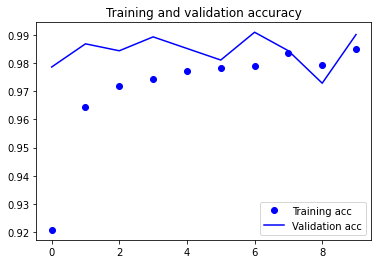

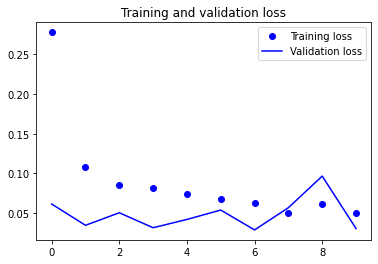

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(height, width),
        batch_size=1,
        class_mode='categorical')

Found 1211 images belonging to 11 classes.


In [31]:
model.evaluate_generator(test_generator,verbose=1)

1211/1211 [==============================] - 37s 31ms/step - loss: 0.0384 - acc: 0.9893


[0.038369266174336995, 0.9892651]

Best test accuracy till now: 0.9909166